# This notebook is designed for filtering and interactive picking of first arrivals from the Apollo active seismic experiment

### Getting the data

In [ ]:
"""
For this notebook, I'll use the segy-formatted data* hosted by 
JAXA at this address (as of July 2023):
https://www.darts.isas.jaxa.jp/planet/seismology/apollo/ASE.html

*[Brzostowski, M., & Brzostowski, A. (2009). 
Archiving the Apollo active seismic data. 
The Leading Edge, 28(4), 414-416.]
"""

## example of downloading the .segy files to a specified local directory
import requests

savefile = "../your/chosen/path/apollo16_shot1.sgy"
url = "https://data.darts.isas.jaxa.jp/pub/apollo/ase/Apollo16/Shot%201_apollo_16.segy"
r = requests.get(url, allow_redirects=True)
open(savefile, 'wb').write(r.content)

### Test plot of the data

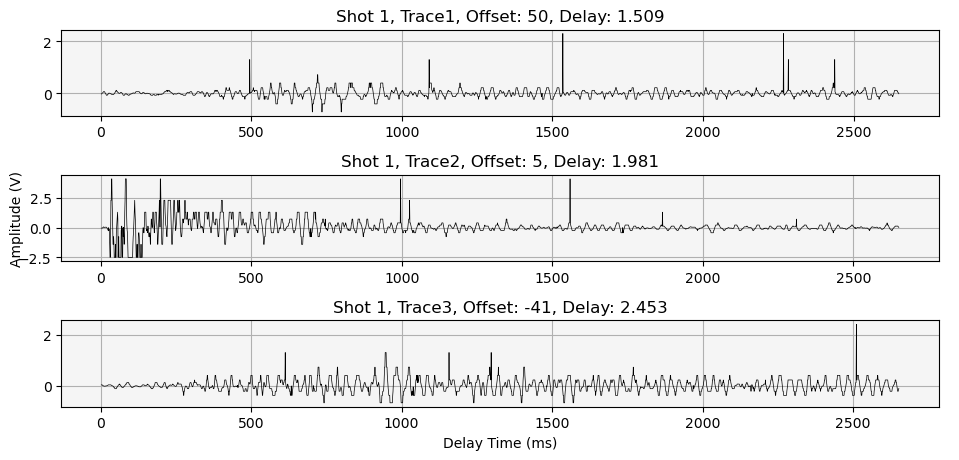

In [2]:
"""
Each segy file contains 3 traces, corresponding to the 3 geophones
recording during each shot. Each segy file corresponds to a separate
shot. Using the open-source library, `segyio`, we can open these
files and return each recorded trace as a NumPy array along with
metadata stored in the segy headers.

NOTE: the offset distances in the segy headers appear to be rounded
to the nearest integer, although nominal shot spacing was 4.57m. 
Additionally, the `samples` file header only corresponds to Geophone 1
"""
import segyio
import matplotlib.pyplot as plt
import numpy as np

segypath = "../data/Apollo16/shot10.sgy"
with segyio.open(segypath) as segyfile:
    shot1 = {}
    for i in range(len(segyfile.trace)):
        shot1["trace"+str(i+1)] = {}

        offset = segyfile.header[i][segyio.TraceField.offset]
        samplerate = segyfile.header[i][segyio.TraceField.TRACE_SAMPLE_INTERVAL]
        delay = segyfile.header[i][segyio.TraceField.DelayRecordingTime] / 1000
        time = np.arange(len(segyfile.trace[i])) + delay
        
        shot1["trace"+str(i+1)]["trace"] = segyfile.trace[i]
        shot1["trace"+str(i+1)]["time"] = time
        shot1["trace"+str(i+1)]["samplerate"] = samplerate
        shot1["trace"+str(i+1)]["offset"] = offset
        shot1["trace"+str(i+1)]["delay"] = delay

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,5))
trace_color = "black"
line_width = 0.5
ax[0].plot(shot1['trace1']['time'], shot1['trace1']['trace'], color=trace_color, lw=line_width)
ax[0].set(facecolor="whitesmoke", axisbelow=True,
         title=f"Shot 1, Trace1, Offset: {shot1['trace1']['offset']}, Delay: {shot1['trace1']['delay']}")
ax[0].grid("both")
ax[1].plot(shot1['trace2']['time'], shot1['trace2']['trace'], color=trace_color, lw=line_width)
ax[1].set(facecolor="whitesmoke", axisbelow=True,
         title=f"Shot 1, Trace2, Offset: {shot1['trace2']['offset']}, Delay: {shot1['trace2']['delay']}")
ax[1].grid("both")
ax[2].plot(shot1['trace3']['time'], shot1['trace3']['trace'], color=trace_color, lw=line_width)
ax[2].set(facecolor="whitesmoke", axisbelow=True,
         title=f"Shot 1, Trace3, Offset: {shot1['trace3']['offset']}, Delay: {shot1['trace3']['delay']}")
ax[2].grid("both")

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Delay Time (ms)")
plt.ylabel("Amplitude (V)")
plt.tight_layout()
plt.show()

## Analyzing the data

In [3]:
## imports

import segyio
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, lfilter, hilbert

In [4]:
## helper functions

def load_apollo_shot(segypath):
    """
    Load a single segyfile of Apollo active seismic data.
    Return a dictionary containing the three seismic
    traces and useful metadata. Manually overwrite the
    offset information since this was rounded in the
    segy header (assuming Apollo 16 experiment offsets).
    """
    ## offsets for teh 3 geophones of Apollo 16
    g3_offsets = np.array([i*4.57 for i in range(21)])
    missed_shot_idxs = [11, 19]
    g3_offsets = np.delete(g3_offsets, missed_shot_idxs)
    g2_offsets = np.abs(g3_offsets-45.7)
    g1_offsets = np.abs(g3_offsets-np.amax(g3_offsets))
    offsets = [g1_offsets, g2_offsets, g3_offsets]
    
    with segyio.open(segypath) as segyfile:
        shot = {}
        for i in range(len(segyfile.trace)):
            offset = offsets[i]
            samplerate = segyfile.header[i][segyio.TraceField.TRACE_SAMPLE_INTERVAL]
            delay = segyfile.header[i][segyio.TraceField.DelayRecordingTime] / 1000
            time = np.arange(len(segyfile.trace[i])) + delay
            
            shot["trace"+str(i+1)] = {}
            shot["trace"+str(i+1)]["trace"] = segyfile.trace[i]
            shot["trace"+str(i+1)]["time"] = time
            shot["trace"+str(i+1)]["samplerate"] = samplerate
            shot["trace"+str(i+1)]["offset"] = offset
            shot["trace"+str(i+1)]["delay"] = delay
    return shot


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [59]:
print(shot1)

{'trace1': {'trace': array([0.021 , 0.021 , 0.0065, ..., 0.038 , 0.038 , 0.038 ], dtype=float32), 'time': array([8.490000e-01, 1.849000e+00, 2.849000e+00, ..., 2.647849e+03,
       2.648849e+03, 2.649849e+03]), 'samplerate': 1887, 'offset': array([91.4 , 86.83, 82.26, 77.69, 73.12, 68.55, 63.98, 59.41, 54.84,
       50.27, 45.7 , 36.56, 31.99, 27.42, 22.85, 18.28, 13.71,  9.14,
        0.  ]), 'delay': 0.849}, 'trace2': {'trace': array([ 0.039,  0.039,  0.07 , ..., -0.041, -0.041, -0.074], dtype=float32), 'time': array([1.321000e+00, 2.321000e+00, 3.321000e+00, ..., 2.648321e+03,
       2.649321e+03, 2.650321e+03]), 'samplerate': 1887, 'offset': array([45.7 , 41.13, 36.56, 31.99, 27.42, 22.85, 18.28, 13.71,  9.14,
        4.57,  0.  ,  9.14, 13.71, 18.28, 22.85, 27.42, 31.99, 36.56,
       45.7 ]), 'delay': 1.321}, 'trace3': {'trace': array([-0.036, -0.036, -0.036, ...,  0.23 ,  0.41 ,  0.41 ], dtype=float32), 'time': array([1.792000e+00, 2.792000e+00, 3.792000e+00, ..., 2.648792e+03,


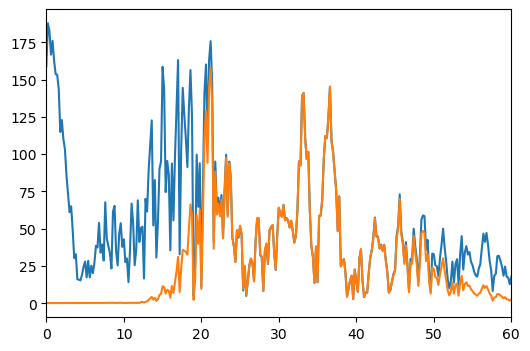

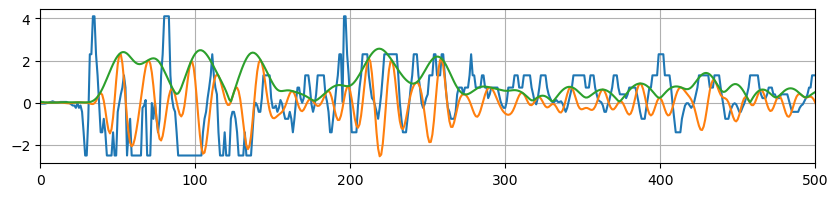

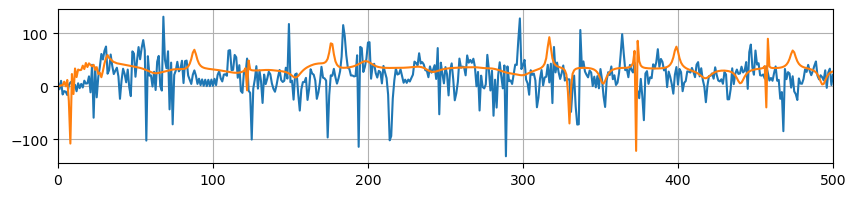

In [12]:
shot1 = load_apollo_shot("../data/Apollo16/shot10.sgy")

x = shot1['trace2']['trace']
fs = shot1['trace2']['samplerate'] / 1e6
X = np.fft.fft(x)
real_vals = range(len(x)//2)
freqs = np.fft.fftfreq(len(x), d=fs)
# freqs = np.fft.fftshift(freqs)



## apply butterworth
lowcut = 20
highcut = 50
filtered_sig = butter_bandpass_filter(x, lowcut, highcut, 1/fs, order=5)
X_filt = np.fft.fft(filtered_sig)

hilbert_sig = np.abs(hilbert(filtered_sig))

inst_freq_orig = inst_freq(x, fs)
inst_freq_filt = inst_freq(filtered_sig, fs)

plt.figure(figsize=(6,4))
plt.plot(freqs[real_vals], np.abs(X)[real_vals])
plt.plot(freqs[real_vals], np.abs(X_filt)[real_vals])
plt.xlim(0, 60)
plt.show()

# trace_lim_idxs = (None, None)
trace_lim_idxs = (0, 500)

plt.figure(figsize=(10,2))
plt.plot(x)
plt.plot(filtered_sig)
plt.plot(hilbert_sig)
plt.grid("both")
plt.xlim(trace_lim_idxs[0], trace_lim_idxs[1])
plt.show()

plt.figure(figsize=(10,2))
plt.plot(inst_freq_orig)
plt.plot(inst_freq_filt)
plt.grid("both")
plt.xlim(trace_lim_idxs[0], trace_lim_idxs[1])
plt.show()

In [6]:
def quadrature(traces):
    h = hilbert(traces)
    return np.abs(h) * np.sin(np.log(h).imag)

def inst_freq(traces, dt):
    """
    Bruges
    Args:
        traces (ndarray): The data array to use for calculating energy.
        dt (float): The sample interval in seconds, e.g. 0.004 for 4 ms sample
            interval (250 Hz sample frequency).
    Returns:
        ndarray: An array the same dimensions as the input array.
    """
    y = quadrature(traces)
    expr = (traces[:-1] * y[1:] - traces[1:] * y[:-1]) / (traces[:-1] * traces[1:] + y[1:] * y[:-1])
    return (1 / (2 * np.pi * dt)) * np.arctan(expr)